In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math
#!cat ./coverage_probabilities_patricia.py
#from coverage_probabilities_patricia import get_coverage_probabilities_nomodel

Load dataset (real values and model predictions)

In [12]:

index_sh=np.load('../saved_models/index_sh_1e5.npy')
percentiles=np.load('../input_dataset/percentiles_100000.npy')
y=percentiles[index_sh,:][90000:,:]
#y=y[:1000,:]
y_pred=np.load('../means_1e5_none_full.npy')
y_pred_std=np.load('../stds_1e5_none_full.npy')

"""
index_sh=np.load('../saved_models/index_sh_1e4.npy')
percentiles=np.load('../input_dataset/percentiles_1e4.npy')
y=percentiles[index_sh,:][9000:,:]
y_pred=np.load('../saved_models/means_1e4.npy')
y_pred_std=np.load('../saved_models/stds_1e4.npy')
"""

"\nindex_sh=np.load('../saved_models/index_sh_1e4.npy')\npercentiles=np.load('../input_dataset/percentiles_1e4.npy')\ny=percentiles[index_sh,:][9000:,:]\ny_pred=np.load('../saved_models/means_1e4.npy')\ny_pred_std=np.load('../saved_models/stds_1e4.npy')\n"

En estadística, para valores no negativos de $x$, la función error tiene la siguiente interpretación: para una variable aleatoria $Y$ que sigue una distribución normal con media 0 y varianza $1 / 2, \operatorname{erf}(x)$ es la probabilidad de que $Y$ caiga en el intervalo $[-x, x]$.

In [6]:
def get_coverage_probabilities_nomodel(y_real,y_pred,y_pred_std):
    """
    Compute the coverage probabilities on test dataset
    
    :param y:  The data true values
    :param y_pred: The mean of the predicted distributions
    :param y_pred_std: The standard deviation of the predicted distributions
    :return: (x, y) a tuple of lists corresponding to a list of probability volumes
    and the corresponding percentage of true values in that volume.
    """
    

    errors = np.absolute(y_real - y_pred)
    x, y = [], []
    for sigma_times in np.arange(0, 3, 0.01):
        how_many = np.count_nonzero(errors <= sigma_times * y_pred_std)
        y.append(how_many / y_real.shape[0])
        x.append(math.erf(sigma_times / math.sqrt(2))) #the method erf returns the error function of a number.
    return x, y


def plot_with_median(data_x, data_y,ax, label=None, percentiles=(16, 84), total_bins=20):
    """
    Plot the running media of the data_x, data_y data with requested percentiles.
    :param data_x:
    :param data_y:
    :param label: The label that should be displayed on the legend
    :param percentiles: The percentiles to plot along with the median
    :param total_bins: The number of bins to digitize the data. Increase to increase detail.
    :return:
    """
    bins = np.linspace(data_x.min(), data_x.max(), total_bins)

    delta = bins[1] - bins[0]
    idx = np.digitize(data_x, bins)
    running_median = [np.nanmedian(data_y[idx == k]) for k in range(total_bins)]
    running_prc_low = [np.nanpercentile(data_y[idx == k], percentiles[0])
                       for k in range(total_bins)]
    running_prc_high = [np.nanpercentile(data_y[idx == k], percentiles[1])
                        for k in range(total_bins)]

    if percentiles:
        ax.plot(bins-delta/2, running_median, lw=2, alpha=.8, color='blue', label=label)
        ax.fill_between(bins - delta / 2, running_prc_low, running_median, color='blue', alpha=0.1)
        ax.fill_between(bins - delta / 2, running_prc_high, running_median, color='blue', alpha=0.1)
    else:
        ax.plot(bins - delta / 2, running_median, linestyle='--', lw=2, alpha=.8,  label=label)
        
        
def init_coverage_plot():
    """
    Initialize the coverage plot and add text for marking
    overconfident and conservative regions
    :return:
    """
    f = plt.figure(figsize=(10, 8))
    ax = f.add_subplot()
    ax.set_xlabel('Percentage of probability volume')
    ax.set_ylabel('Percentage of true values in volume')
    ax.set_title('Probability Coverage')

    plt.plot([0, 1], [0, 1], '--', label='Perfect Calibration')
    plt.text(0.3, 0.9, '$\it{Conservative}$',
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes)

    plt.text(0.7, 0.1, '$\it{Overconfident}$',
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes)
    return f, ax

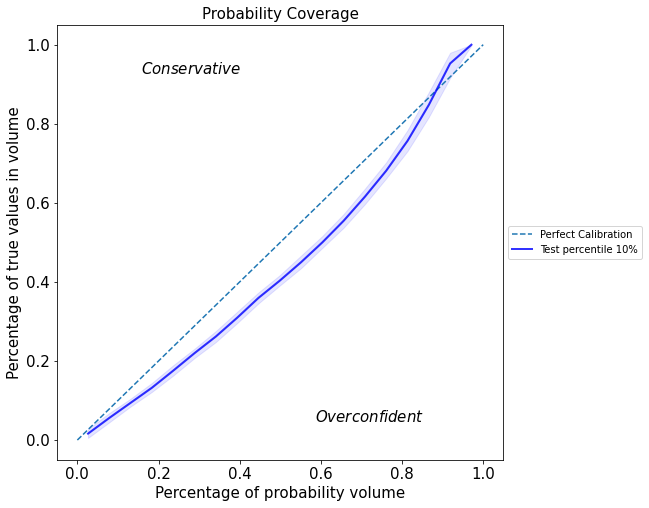

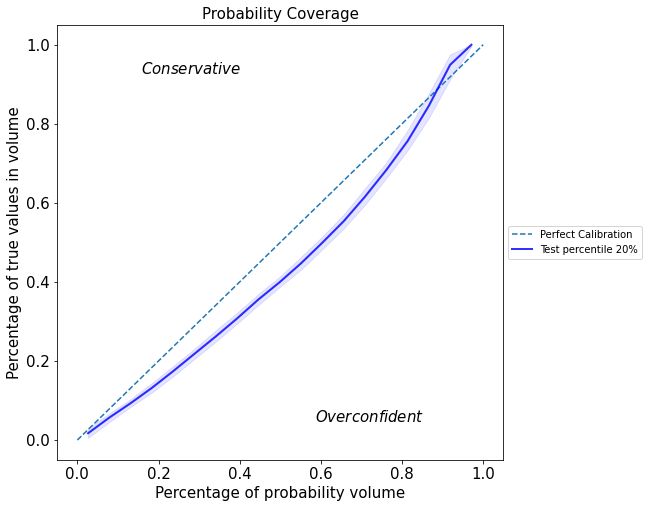

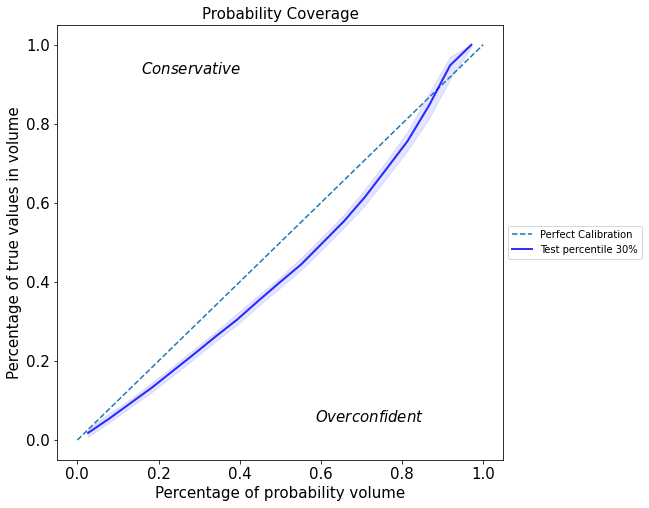

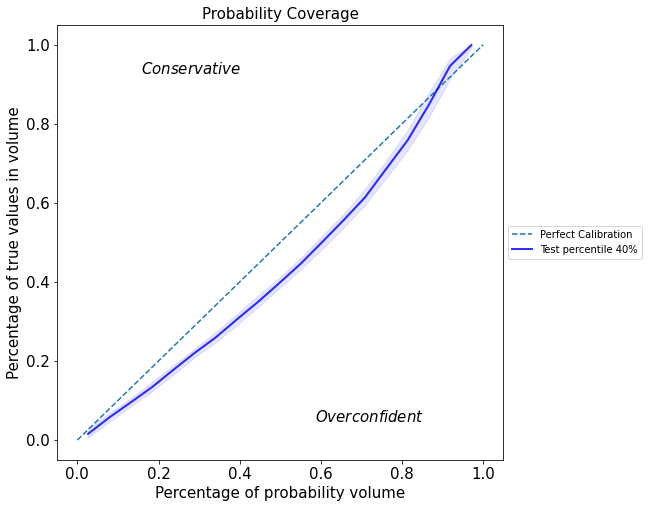

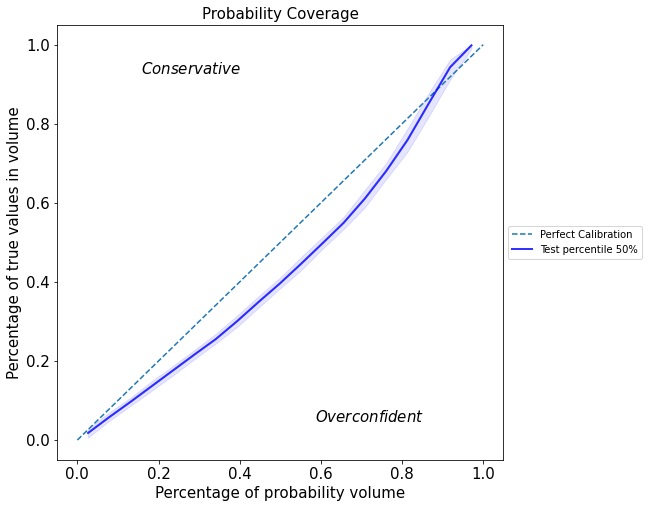

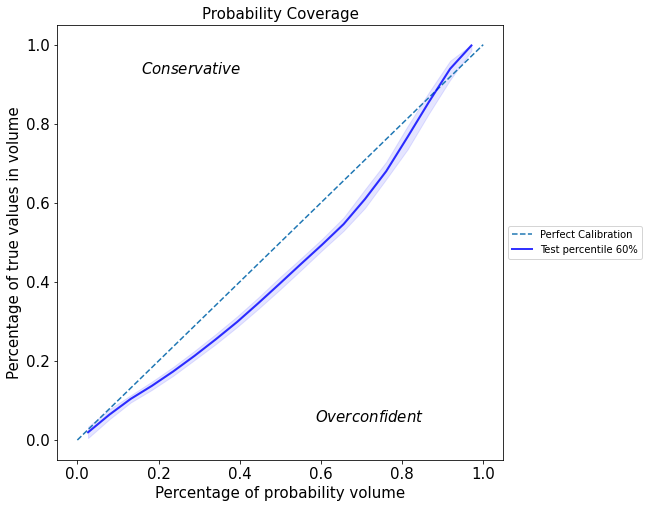

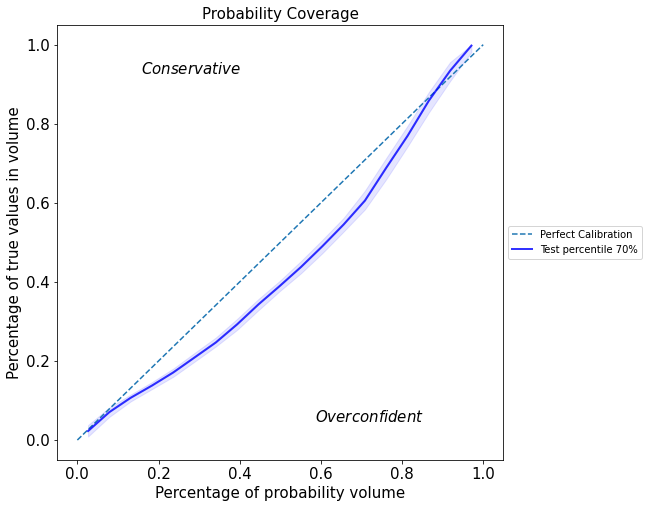

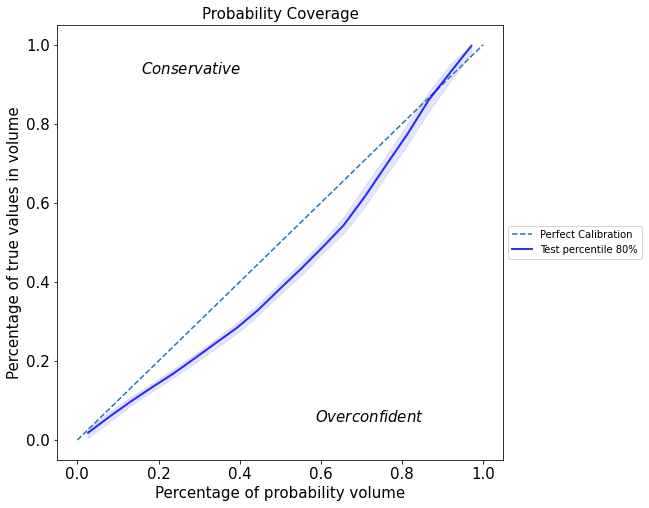

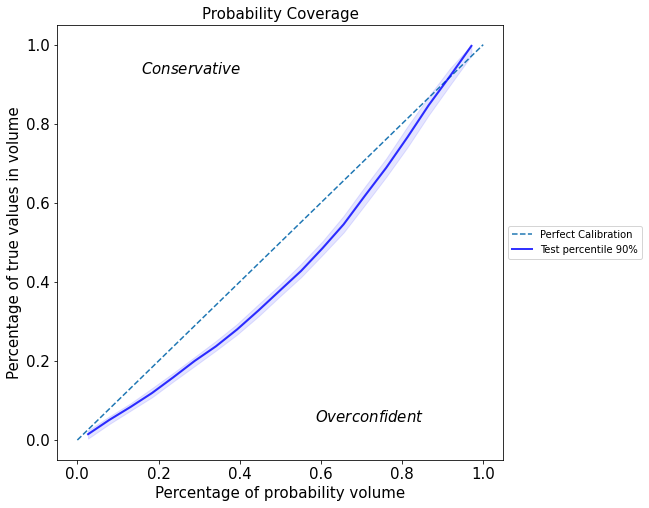

In [13]:
for i in range(9):
    
    data_x,data_y=get_coverage_probabilities_nomodel(np.array(y)[:,i],y_pred[:,i],y_pred_std[:,i])
    plt.rcParams.update({'font.size': 15})
    plt.rc('axes', titlesize=15, labelsize=15)
    f, ax =init_coverage_plot()

    plot_with_median(np.array(data_x), np.array(data_y), ax, label='Test percentile '+str((i+1)*10)+'%')

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

    #f.savefig('coverage.png')
    plt.show()
    plt.close()
